- Intro
- Acquire
- Prepare
- Univariate Explore
- Split
- Explore/Stats
- Kmeans, binning, feature engineering
    combining features:
    - rooms (bed, bath) - ratio in one col?
    - size (square, lot, garage)
    - extras (pool, garage)
    - year
    - location & (code)
- Additional explore/stats
- takeaways about log error drivers
- modeling pre (different codes)
- modeling
- model summary
- conclusion

### INTRO

### IMPORTS/ACQUIRE

In [1]:
# Imports necessary to acquire, prepare, explore, visualize, analyze, and model data

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env
import acquire
import prepare

from tabulate import tabulate
from IPython.display import Markdown, display

from math import sqrt
from scipy import stats

import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import sklearn.preprocessing
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from scipy.cluster.vq import kmeans2, whiten

np.random.seed(12)

In [2]:
df = acquire.get_zillow_data()
df = prepare.remove_outliers(df)
df = prepare.handle_nulls(df)
df = prepare.rename_columns(df)
df = prepare.prepare_locs(df)

### note: add to prepare...

In [3]:
df = df[(df.propertycountylandusecode == '0100') | (df.propertycountylandusecode == '122') | (df.propertycountylandusecode == '0101') | (df.propertycountylandusecode == '1111') | (df.propertycountylandusecode == '1') | (df.propertycountylandusecode == '1110') | (df.propertycountylandusecode == '0104')]

In [4]:
df = df[(df.log_error > -.4) & (df.log_error < .4)]

In [5]:
df = df[(df.propertycountylandusecode == '1111')]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3257 entries, 9 to 52438
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   parcelid                   3257 non-null   int64         
 1   bathrooms                  3257 non-null   float64       
 2   bedrooms                   3257 non-null   float64       
 3   square_feet                3257 non-null   int64         
 4   fips                       3257 non-null   int64         
 5   garages                    3257 non-null   int64         
 6   garage_size                3257 non-null   int64         
 7   lot_size                   3257 non-null   int64         
 8   has_pool                   3257 non-null   bool          
 9   propertycountylandusecode  3257 non-null   object        
 10  propertylandusetypeid      3257 non-null   float64       
 11  year_built                 3257 non-null   int64         
 12  taxva

In [7]:
#ex = train[(train.county == 'orange') & (train.square_feet > 2400) & (train.lot_size > 18975)]

### note : talk about % of data still here, what was dropped, why, handling nulls and outliers

### SPLIT
### note: make in function

In [8]:
train, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train, test_size=.3, random_state=123)
# Splits data into 3 subsets: train, validate, test. Random state specifying that data is split
# with the exact same records when the code is re-run (useful for exploration and modeling, yet
# I suggest dropping this when employing the model)

def printmd(string): # function to format text style
    display(Markdown(string))
print()
printmd('**Number of Train Records:** {:,}'
     .format(len(train)))
printmd('**Number of Validate Records:** {:,}'
     .format(len(validate)))
printmd('**Number of Test Records:** {:,}'
     .format(len(test)))
# returns the amount of records in each subset after splitting

**Number of Train Records:** 1,823

**Number of Validate Records:** 782

**Number of Test Records:** 652

### EXPLORE

- Ask questions
- what is driving logerror?
- hypothesize homes that don't quite fit normal patterns(take drivers from tax value into account) - ie. older home that has a very high value and/or square feet, very small home with high value, strange ratio of bed to bath
- does location impact error (are some locations harder to predict?)

### STATS

### Feature Eng

In [9]:
X = train[['bedrooms', 'bathrooms']]
XVAL = validate[['bedrooms', 'bathrooms']]
XTEST = test[['bedrooms', 'bathrooms']]

kmeans = KMeans(n_clusters=6)
kmeans.fit(X)

kmeans.predict(X)

train['room_cluster'] = kmeans.predict(X)
validate['room_cluster'] = kmeans.predict(XVAL)
test['room_cluster'] = kmeans.predict(XTEST)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

,bedrooms,bathrooms
0,2.981395,2.630233
1,4.001869,2.166355
2,2.898367,1.906534
3,4.812500,4.177083
4,3.986885,3.172131
5,5.000000,2.719008


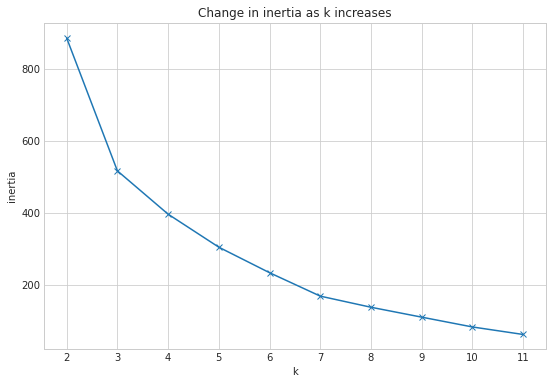

In [10]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [11]:
num_vars = train[['lot_size', 'square_feet', 'bedrooms', 'bathrooms', 'latitude', 'longitude']]
num_vars1 = validate[['lot_size', 'square_feet', 'bedrooms', 'bathrooms', 'latitude', 'longitude']]
num_vars2 = test[['lot_size', 'square_feet', 'bedrooms', 'bathrooms', 'latitude', 'longitude']]

scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(num_vars)
train_s = (num_vars)
validate_s = (num_vars1)
test_s = (num_vars2)

X = scaler.transform(num_vars)
X1 = scaler.transform(num_vars1)
X2 = scaler.transform(num_vars2)

X = pd.DataFrame(X, index=train_s.index, columns=train_s.columns)
X1 = pd.DataFrame(X1, index=validate_s.index, columns=validate_s.columns)
X2 = pd.DataFrame(X2, index=test_s.index, columns=test_s.columns)

clustering = DBSCAN(eps = .1, min_samples = 30).fit(X)
clustering1 = DBSCAN(eps = .1, min_samples = 30).fit(X1)
clustering2 = DBSCAN(eps = .1, min_samples = 30).fit(X2)

train['DB_lot']=clustering.labels_
validate['DB_lot']=clustering1.labels_

test['DB_lot']=clustering2.labels_

In [12]:
# X = train[['square_feet','garages', 'has_pool']]

# kmeans = KMeans(n_clusters=4)
# kmeans.fit(X)

# kmeans.predict(X)

# train['extras_cluster'] = kmeans.predict(X)

# centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
# centroids

In [13]:
# bins = [-.6, -.0475, -.0244, -.0106, 0, .0125, .0283, .0586, .6]
# labels = ['N4','N3','N2','N1', 'P1', 'P2', 'P3', 'P4']
# train['log_error_bin'] = pd.cut(train['log_error'], bins=bins, labels=labels)
# validate['log_error_bin'] = pd.cut(validate['log_error'], bins=bins, labels=labels)
# test['log_error_bin'] = pd.cut(test['log_error'], bins=bins, labels=labels)

In [14]:
train['garages'] = train.garages.astype(bool)
train['has_pool'] = train.has_pool.astype(bool)

validate['garages'] = validate.garages.astype(bool)
validate['has_pool'] = validate.has_pool.astype(bool)

test['garages'] = test.garages.astype(bool)
test['has_pool'] = test.has_pool.astype(bool)

train['garages'] = train.garages.astype(int)
train['has_pool'] = train.has_pool.astype(int)

validate['garages'] = validate.garages.astype(int)
validate['has_pool'] = validate.has_pool.astype(int)

test['garages'] = test.garages.astype(int)
test['has_pool'] = test.has_pool.astype(int)

train['extras'] = (train['garages']) + (train['has_pool'])
validate['extras'] = (validate['garages']) + (validate['has_pool'])
test['extras'] = (test['garages']) + (test['has_pool'])

In [15]:
train.extras.value_counts()

1    1448
2     370
0       5
Name: extras, dtype: int64

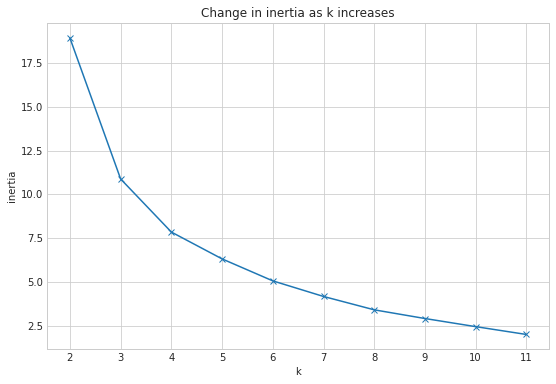

In [16]:
X = train[['latitude', 'longitude']]

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [17]:
X = train[['latitude', 'longitude']]
XV = validate[['latitude', 'longitude']]
XT = test[['latitude', 'longitude']]

kmeans = KMeans(n_clusters=20)
kmeans.fit(X)

train['cluster_locs'] = kmeans.predict(X)
validate['cluster_locs'] = kmeans.predict(XV)
test['cluster_locs'] = kmeans.predict(XT)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

,latitude,longitude
0,34.151377,-118.843203
1,34.270163,-119.174521
2,34.197140,-118.895815
3,34.272464,-118.745624
4,34.227088,-119.002437
5,34.400813,-118.922558
6,34.435782,-119.270262
7,34.207221,-119.196176
8,34.215667,-118.845695
9,34.173138,-118.959014


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

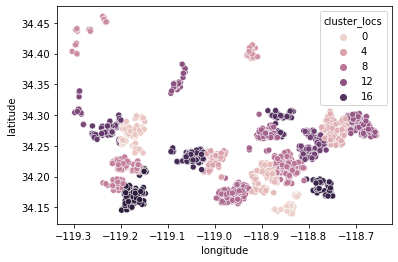

In [18]:
sns.scatterplot(data=train, x='longitude', y='latitude', hue='cluster_locs')

In [19]:
train['total_size'] = (train['lot_size']) + (train['square_feet'])
validate['total_size'] = (validate['lot_size']) + (validate['square_feet'])
test['total_size'] = (test['lot_size']) + (test['square_feet'])

In [20]:
# train = train[train.log_error > -0.2]
# train = train[train.log_error < 0.2]

In [21]:
bins = [-.07,  0, .07]
labels = ['N1', 'P1']
train['log_error_bin'] = pd.cut(train['log_error'], bins=bins, labels=labels)
validate['log_error_bin'] = pd.cut(validate['log_error'], bins=bins, labels=labels)
test['log_error_bin'] = pd.cut(test['log_error'], bins=bins, labels=labels)

In [22]:
train_neg = train.where(train.log_error < 0).dropna()
train_pos = train.where(train.log_error > 0).dropna()

In [23]:
train['log_error_binn'] = train['log_error_bin'].replace(['N1'],'P1')
train['log_error_binn'] = train['log_error_binn'].replace(['N2'],'P2')

validate['log_error_binn'] = validate['log_error_bin'].replace(['N1'],'P1')
validate['log_error_binn'] = validate['log_error_binn'].replace(['N2'],'P2')

test['log_error_binn'] = test['log_error_bin'].replace(['N1'],'P1')
test['log_error_binn'] = test['log_error_binn'].replace(['N2'],'P2')

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1823 entries, 33674 to 39431
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   parcelid                   1823 non-null   int64         
 1   bathrooms                  1823 non-null   float64       
 2   bedrooms                   1823 non-null   float64       
 3   square_feet                1823 non-null   int64         
 4   fips                       1823 non-null   int64         
 5   garages                    1823 non-null   int64         
 6   garage_size                1823 non-null   int64         
 7   lot_size                   1823 non-null   int64         
 8   has_pool                   1823 non-null   int64         
 9   propertycountylandusecode  1823 non-null   object        
 10  propertylandusetypeid      1823 non-null   float64       
 11  year_built                 1823 non-null   int64         
 12  t

In [25]:
X_train = train[['bedrooms', 'bathrooms', 'square_feet', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'year_built', 'lot_size', 'DB_lot', 'total_size', 'room_cluster', 'extras']]
y_train = train[['log_error_bin']]

X_validate = validate[['bedrooms', 'bathrooms', 'square_feet', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'year_built', 'lot_size', 'DB_lot', 'total_size', 'room_cluster', 'extras']]
y_validate = validate[['log_error_bin']]

X_test = test[['bedrooms', 'bathrooms', 'square_feet', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'year_built', 'lot_size', 'DB_lot', 'total_size', 'room_cluster', 'extras']]
y_test = test[['log_error_bin']]

In [26]:
184/314

0.5859872611464968

In [27]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE

In [28]:


# initialize the ML algorithm
lm = DecisionTreeClassifier()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=6)

# fit the data using RFE
rfe.fit(X_train,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train.iloc[:,feature_mask].columns.tolist()

rfe_feature

ValueError: Input contains NaN

In [ ]:
clf = DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

In [ ]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)

In [ ]:
rf.fit(X_train, y_train)
RandomForestClassifier(max_depth=1, min_samples_leaf=2, random_state=123)

In [ ]:
print(rf.feature_importances_)

In [ ]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

In [ ]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

In [ ]:
y_pred = rf.predict(X_train)

In [ ]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation (contiuous variables) of to Log Error")
corr_chart = train.drop(['log_error'], axis=1).corrwith(train['log_error']).sort_values().plot.barh()
corr_chart

In [ ]:
train = train[train.DB_locs != -1]
validate = validate[validate.DB_locs != -1]
test = test[test.DB_locs != -1]